In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit as logistic


from causalgraphicalmodels import CausalGraphicalModel

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [ ]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std()

## Ex. 1

In [ ]:
df = pd.read_csv('data/NWOGrants.csv', sep=';')

In [ ]:
gender_id = pd.factorize(df.gender)[0]
gender_idx = pd.factorize(df.gender)[1]

In [ ]:
df.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


Model definition 

\begin{split}\begin{aligned}
A_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha[G_i] \\
\alpha &\sim Normal(0, 1) \\

\end{aligned}\end{split}




In [ ]:
#check prior implications
with pm.Model() as m5_1:
        a = pm.Normal("a", 0, 1)
        p = pm.Deterministic("p", pm.math.invlogit(a))

        awards = pm.Binomial("awards", 1, p, observed=df.awards)
        
        prior_5_1 = pm.sample_prior_predictive()
        
idata_5_1 = az.from_pymc3(prior=prior_5_1, model=m5_1)    


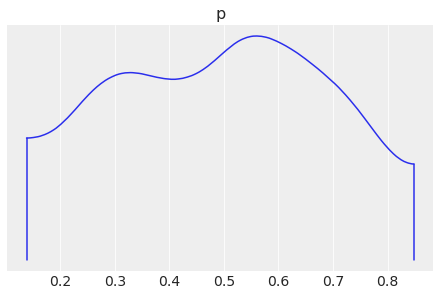

In [ ]:
ax = az.plot_density(
    [idata_5_1],
    var_names =["p"],   
    point_estimate=None,
    group="prior")

In [ ]:
with pm.Model() as m5_2:

        a = pm.Normal("a", 0, 1, shape=len(gender_idx)) #one for each gender
        p = pm.Deterministic("p", pm.math.invlogit(a[gender_id]))

        awards = pm.Binomial("awards", p=p, n=df.applications, observed=df.awards)
        
        prior_5_2 = pm.sample_prior_predictive()
        trace_5_2 = pm.sample(draws=10000)

idata_5_2 = az.from_pymc3(trace_5_2,model=m5_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.


In [ ]:
pm.summary(trace_5_2, var_names=['a'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.529,0.065,-1.651,-1.407,0.0,0.0,34015.0,27665.0,1.0
a[1],-1.733,0.081,-1.884,-1.581,0.0,0.0,35726.0,26784.0,1.0


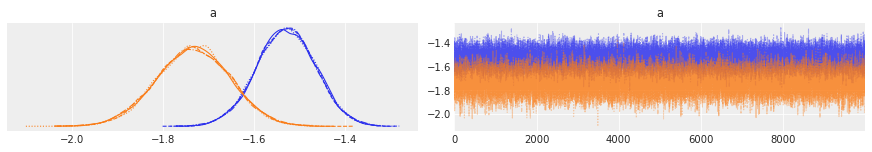

In [ ]:
with m5_2:
    tr = pm.plot_trace(trace_5_2, var_names=['a'])
tr;    

In [ ]:
#difference calculations using inference data object
diff_a = idata_5_2['posterior']['a'].sel(a_dim_0=0).values - idata_5_2['posterior']['a'].sel(a_dim_0=1).values
diff_p = logistic(idata_5_2['posterior']['a'].sel(a_dim_0=0).values) - logistic(idata_5_2['posterior']['a'].sel(a_dim_0=1).values)
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.20,0.10,0.01,0.40
diff_p,0.03,0.01,0.00,0.05


In [ ]:
#the same calculation using trace
diff_a_1 = trace_5_2["a"][:,0] - trace_5_2["a"][:,1]
diff_p_1 = logistic(trace_5_2["a"][:,0]) - logistic(trace_5_2["a"][:,1])
az.summary({"diff_a": diff_a_1, "diff_p": diff_p_1}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.20,0.10,0.01,0.40
diff_p,0.03,0.01,0.00,0.05


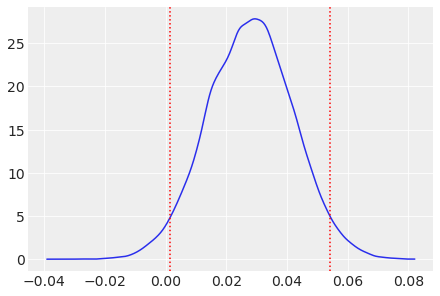

In [ ]:
hdi_l, hdi_h = az.hdi(diff_p_1)
hdi_l, hdi_h

fig, ax = plt.subplots()
az.plot_kde(diff_p_1, ax=ax)
ax.axvline(x=hdi_l,color='red',linestyle=':')
ax.axvline(x=hdi_h,color='red',linestyle=':')

In [ ]:
#total causal effect: men more likely to be awarded then women

## Ex. 2

In [2]:
#second model: gender and discipline
df = pd.read_csv('data/NWOGrants.csv', sep=';')

In [12]:
#do a quick numbers check
x = df.groupby(['discipline','gender']).agg({
    'applications':'sum',
    'awards':'sum'
}).reset_index()

x['award_rate'] = round(x['awards']/x['applications'],2)
x.sort_values(by=['discipline','gender'])


,discipline,gender,applications,awards,award_rate
0,Chemical sciences,f,39,10,0.26
1,Chemical sciences,m,83,22,0.27
2,Earth/life sciences,f,126,18,0.14
3,Earth/life sciences,m,156,38,0.24
4,Humanities,f,166,32,0.19
5,Humanities,m,230,33,0.14
6,Interdisciplinary,f,78,17,0.22
7,Interdisciplinary,m,105,12,0.11
8,Medical sciences,f,260,29,0.11
9,Medical sciences,m,245,46,0.19


In [5]:
gender_id = pd.factorize(df.gender)[0]
gender_idx = pd.factorize(df.gender)[1]

discipline_id = pd.factorize(df.discipline)[0]
discipline_idx = pd.factorize(df.discipline)[1]

In [6]:
df.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


Model definition 

\begin{split}\begin{aligned}
A_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha[G_i] + \delta[D_i] \\
\alpha &\sim Normal(0, 1.5) \\
\delta &\sim Normal(0, 1.5) \\


\end{aligned}\end{split}




In [7]:
#model with flexible data input
with pm.Model() as m5_3:

        #define input data
        gender_id = pm.Data("gender_id", gender_id)
        discipline_id = pm.Data("discipline_id", discipline_id)
        applications = pm.Data("applications", df.applications)
        awards = pm.Data("awards", df.awards)

        a = pm.Normal("a", 0.0, 1.5, shape=len(gender_idx))
        delta = pm.Normal("delta", 0, 1.5, shape=len(discipline_idx))

        p = pm.Deterministic("p", pm.math.invlogit(a[gender_id] + delta[discipline_id]))

        awards_hat = pm.Binomial("awards_hat", p=p, n=applications, observed=awards)
        
        prior_5_3 = pm.sample_prior_predictive()
        trace_5_3 = pm.sample(draws=10000)

idata_5_3 = az.from_pymc3(trace_5_3,model=m5_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.
The number of effective samples is smaller than 10% for some parameters.


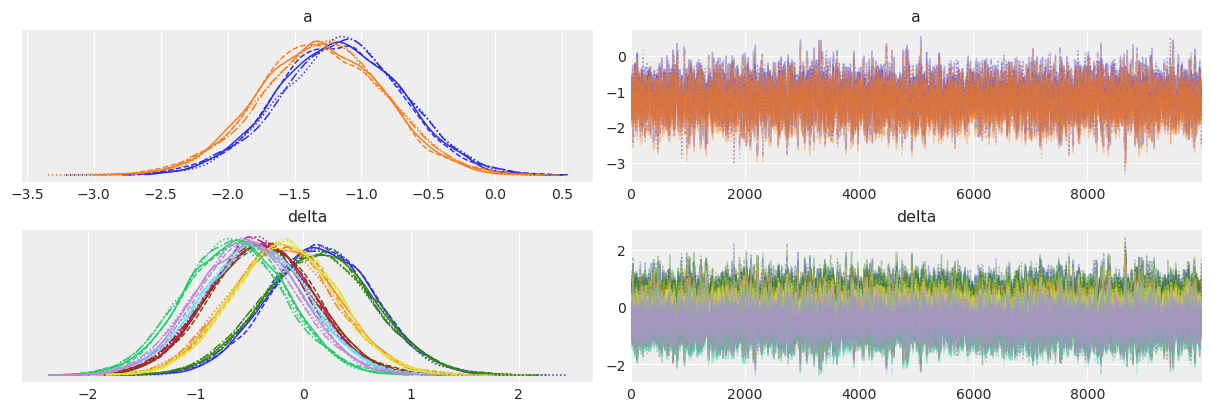

In [9]:
with m5_3:
    tr = pm.plot_trace(trace_5_3, var_names=['a','delta'])
tr;

In [11]:
with m5_3:
    sum = pm.summary(trace_5_3, var_names=['a','delta'])
sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.159,0.464,-2.006,-0.256,0.008,0.005,3723.0,4740.0,1.0
a[1],-1.298,0.467,-2.193,-0.434,0.008,0.005,3775.0,4943.0,1.0
delta[0],0.156,0.498,-0.796,1.076,0.008,0.005,4291.0,6228.0,1.0
delta[1],-0.198,0.493,-1.120,0.728,0.008,0.005,4166.0,5756.0,1.0
delta[2],0.128,0.521,-0.868,1.089,0.008,0.005,4590.0,7040.0,1.0
delta[3],-0.414,0.477,-1.302,0.488,0.008,0.005,3932.0,5424.0,1.0
delta[4],-0.389,0.487,-1.288,0.535,0.008,0.005,4093.0,5722.0,1.0
delta[5],-0.459,0.497,-1.414,0.459,0.008,0.005,4256.0,5998.0,1.0
delta[6],-0.181,0.482,-1.114,0.694,0.008,0.005,4008.0,5545.0,1.0
delta[7],-0.639,0.472,-1.523,0.249,0.008,0.005,3855.0,5249.0,1.0


In [ ]:
#average difference when stratyfing by discipline
diff2_a_1 = trace_5_3["a"][:,0] - trace_5_3["a"][:,1]
diff2_p_1 = logistic(trace_5_3["a"][:,0]) - logistic(trace_5_3["a"][:,1])
az.summary({"diff_a": diff2_a_1, "diff_p": diff2_p_1}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.14,0.11,-0.06,0.34
diff_p,0.02,0.02,-0.01,0.06


In [13]:
#difference per discipline
results = np.zeros((len(discipline_idx), 40000))

for i in range(len(discipline_idx)):
    results[i] = logistic(trace_5_3["a"][:,0] + trace_5_3["delta"][:,i])  - logistic(trace_5_3["a"][:,1] + trace_5_3["delta"][:,i]) 


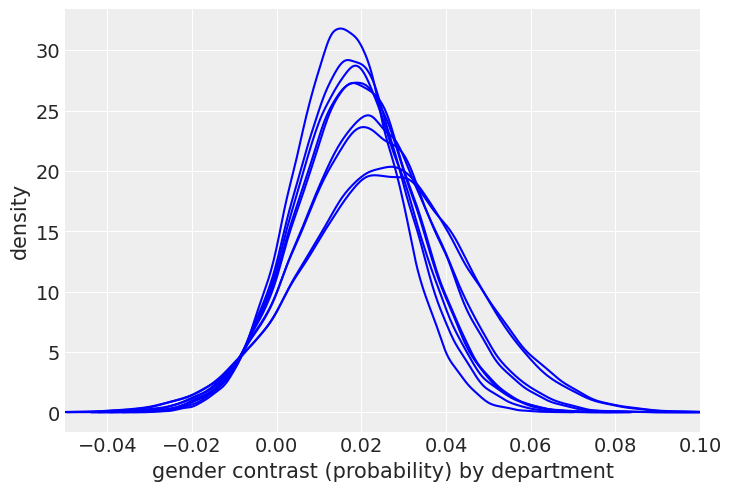

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('gender contrast (probability) by department')
ax.set_ylabel('density')

ax.set_xlim(-0.05, 0.1)

for i in range(len(discipline_idx)):
    az.plot_kde(results[i], ax=ax, plot_kwargs={"color":'b'})



In [ ]:
apps_per_dept = [df[discipline_id == i]['applications'].sum() for i in discipline_ids]


In [ ]:
#averaging over the differences using simulation
discipline_ids = list(range(0,9))

#1) create a list of applications by departments
apps_per_dept = [df[discipline_id == i]['applications'].sum() for i in discipline_ids]

result = []
for i, c in enumerate(apps_per_dept):
    res = [i for x in range(0,c)]
    result.append(res)

result_flat = [item for sublist in result for item in sublist]


In [ ]:
#if applicants were all men
p_men = np.zeros((len(result_flat), 40000))

for e,i in enumerate(result_flat):
        p_men[e] = logistic(trace_5_3["a"][:,0] + trace_5_3["delta"][:,i])
 
#if applicants were all womens
p_women = np.zeros((len(result_flat), 40000))

for e,i in enumerate(result_flat):
        p_women[e] = logistic(trace_5_3["a"][:,1] + trace_5_3["delta"][:,i])



<AxesSubplot:xlabel='gender contrast marginalized (averaged) over all departments', ylabel='density'>

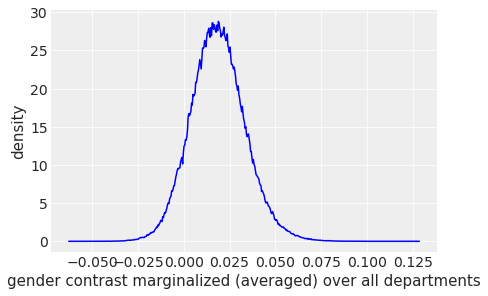

In [ ]:
#visualize difference
fig, ax = plt.subplots()
ax.set_xlabel('gender contrast marginalized (averaged) over all departments')
ax.set_ylabel('density')

az.plot_kde(p_diff, ax=ax, plot_kwargs={"color":'b'})

In [ ]:
p_diff.mean()

0.01867573478487721